In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

/tmp/ipykernel_898658/2477651863.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Conda Environment: tf_env


In [2]:
import matplotlib.pyplot as plt

import numpy as np
import torch

import scipy.io
import scipy.interpolate

import sklearn

from tqdm.notebook import tqdm

import copy
import time
import gc

In [3]:
import sys
# sys.path.append('/n/data1/hms/neurobio/sabatini/rich/github_repos/')
sys.path.append('/media/rich/Home_Linux_partition/github_repos/')

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

%load_ext autoreload
%autoreload 2
from NBAP import import_data, align_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import cascade2p
from cascade2p import checks
checks.check_packages()
from cascade2p import cascade # local folder
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

	YAML reader installed (version 0.17.21).


2022-02-19 18:49:23.082710: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


	Keras installed (version 2.4.0).
	Tensorflow installed (version 2.4.1).


In [5]:
import torchinterp1d

In [6]:
from pathlib import Path

# dir_S2p             = Path(r'/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/20210409/baseline/suite2p/plane0/')
dir_S2p             = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/suite2p/plane0')

# dir_ROIClassifier   = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210418/analysis_lastNight')

dir_ws              = Path(r'/media/rich/bigSSD/res2p/wavesurfer data/round 5 experiments/mouse 2_6/20210417')
fileName_ws         = Path(r'exp_0001.h5')

dir_cameraCSV       = Path(r'/media/rich/bigSSD/res2p/Camera data/round 5 experiments/mouse 2_6/20210417/cam3/experiment')
fileName_cameraCSV  = Path(r'times_cam32021-04-18T00_41_02.csv')

# dir_faceRhythm      = Path(r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run1_vqt/data')
# fileName_faceRhythm = Path('factors_spectral_temporal_interp2.npy')

In [7]:
F , Fneu , iscell , ops , spks , stat , num_frames_S2p = import_data.import_S2p(dir_S2p)

# IsCell_ROIClassifier , ROI_Classifier_manual_selection_vars = import_data.import_roiClassifier(dir_ROIClassifier)

ws_data = import_data.import_ws(dir_ws / fileName_ws)

cameraCSV , signal_GPIO = import_data.import_cameraCSV(dir_cameraCSV / fileName_cameraCSV)

# temporalFactors_faceRhythm = import_data.import_temporalFactorsFR(dir_faceRhythm / fileName_faceRhythm)

## Make alignment templates

### make CAMERA alignment template

convert the absolute times into relative seconds

In [8]:
cameraTimes = align_data.convert_camTimeDates_toAbsoluteSeconds(cameraCSV[:,3])

extract pulses from GPIO

In [9]:
sig_camTimes__idx_cam = cameraTimes
sig_pulses__idx_cam = np.diff(np.int8(np.diff(signal_GPIO, prepend=np.nan) > 1), prepend=np.nan) > 0.5

sig_camTimes__idx_pulses = cameraTimes[sig_pulses__idx_cam]

make template as times relative to the interval between the first and last pulse (rising edge)

In [10]:
sig_camTimesAligned__idx_cam = (cameraTimes - sig_camTimes__idx_pulses[0]) / (sig_camTimes__idx_pulses[-1] - sig_camTimes__idx_pulses[0])

### make WAVESURFER and SCANIMAGE templates

extract SI frame times from recorded flybacks on WS \
AND extract pulse times recorded on WS

In [11]:
ws_galvoFlyBackTrace = ws_data[6]
ws_pulseTrace = ws_data[0]

sig_SIFlybacks__idx_ws = np.diff(np.int8(np.diff(ws_galvoFlyBackTrace, prepend=np.nan) < -1), prepend=np.nan) > 0.5
sig_pulses__idx_ws = np.diff(np.int8(np.diff(ws_pulseTrace, prepend=np.nan) > 1), prepend=np.nan) > 0.5

sig_wsIdx__idx_SIFlybacks = np.where(sig_SIFlybacks__idx_ws)[0]
sig_wsIdx__idx_pulses = np.where(sig_pulses__idx_ws)[0]

make templates as times relative to the interval between the first and last pulse (rising edge)

In [12]:
sig_wsTimesAligned__idx_ws = (np.arange(len(ws_data[0])) - sig_wsIdx__idx_pulses[0]) / (sig_wsIdx__idx_pulses[-1] - sig_wsIdx__idx_pulses[0])
sig_SITimesAligned__idx_SI = (sig_wsIdx__idx_SIFlybacks - sig_wsIdx__idx_pulses[0]) / (sig_wsIdx__idx_pulses[-1] - sig_wsIdx__idx_pulses[0])

store outputs

In [13]:
aligned_trace_times = {'camera': sig_camTimesAligned__idx_cam,
                       'waveSurfer': sig_wsTimesAligned__idx_ws,
                       'scanImage': sig_SITimesAligned__idx_SI}

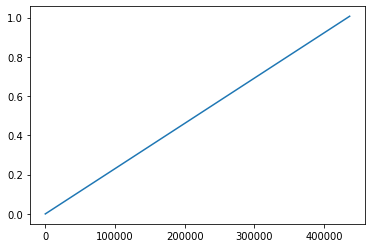

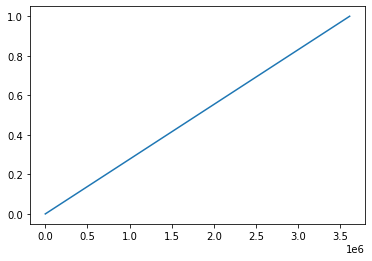

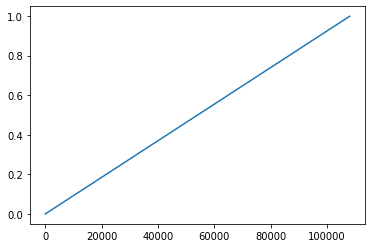

In [14]:
for key,trace in aligned_trace_times.items():
    plt.figure()
    plt.plot(trace)

## Perform alignment
align wavesurfer traces into SI times

In [15]:
licksBool = np.diff(np.diff(ws_data[3], prepend=0) < -1, prepend=0) > 0.5
sig_wsLicks__idx_SI = scipy.interpolate.interp1d(x=aligned_trace_times['waveSurfer'],
                                                 y=licksBool,
                                                 kind='linear')(aligned_trace_times['scanImage'])

rewardsBool = np.diff(np.diff(ws_data[4], prepend=0) > 1, prepend=0) > 0.5
sig_wsRewards__idx_SI = scipy.interpolate.interp1d(x=aligned_trace_times['waveSurfer'],
                                                 y=rewardsBool,
                                                 kind='linear')(aligned_trace_times['scanImage'])

sig_wsTreadmill__idx_SI = scipy.interpolate.interp1d(x=aligned_trace_times['waveSurfer'],
                                                 y=ws_data[2],
                                                 kind='linear')(aligned_trace_times['scanImage'])

sig_wsCursor__idx_SI = scipy.interpolate.interp1d(x=aligned_trace_times['waveSurfer'],
                                                 y=ws_data[5],
                                                 kind='linear')(aligned_trace_times['scanImage'])

store outputs

In [165]:
wsTraces_aligned_to_SI = pd.DataFrame(
    {
        'licks': sig_wsLicks__idx_SI,
        'rewards': sig_wsRewards__idx_SI,
        'treadmill': sig_wsTreadmill__idx_SI,
        'cursor': sig_wsCursor__idx_SI
    }
)

<IPython.core.display.Javascript object>


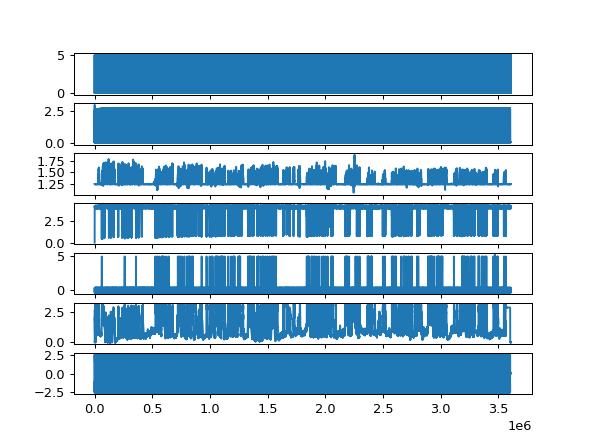

In [166]:
%matplotlib notebook
fig, axs = plt.subplots(ws_data.shape[0], sharex=True)
for ii,ax in enumerate(axs):
    ax.plot(ws_data[ii])

### Save outputs

In [179]:
wsTraces_aligned_to_SI.to_hdf(
    path_or_buf=r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/BMI_IDAP_run/wsTraces_aligned_to_SI__DF.h5',
    key='ws'
)

### Convert logger file to a pandas dataframe h5 file

In [173]:
import pandas as pd
import scipy.io

In [174]:
logger_aligned = scipy.io.loadmat(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/logger_aligned.mat', simplify_cells=True)['logger_aligned']
expParams = scipy.io.loadmat(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/expParams.mat', simplify_cells=True)['expParams']

In [175]:
logger_aligned_df = pd.DataFrame(
    data=logger_aligned['timeSeries'],
    columns=expParams['loggerNames']['timeSeries'],
)

def remove_duplicate_DataFrame_columns(df):
    return df.loc[:,~df.columns.duplicated()]

logger_aligned_df_noDup = remove_duplicate_DataFrame_columns(logger_aligned_df)

In [176]:
logger_aligned_df_noDup.to_hdf(
    path_or_buf=r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/BMI_IDAP_run/logger_aligned__DF.h5', 
    key='logger_aligned',
)

In [ ]:
plt.figure()
plt.plot(ws[])

In [192]:
logger_aligned['decoder']

array([[ 1.97962984e-01,  1.97962984e-01,  1.97962984e-01,
         4.74302783e+03,  1.77729082e+00],
       [ 4.03668955e-02,  4.03668955e-02,  4.03668955e-02,
         4.04787842e+03,  1.59634709e+00],
       [ 0.00000000e+00, -5.69496490e-03,  0.00000000e+00,
         3.88684920e+03,  1.55000000e+00],
       ...,
       [            nan,             nan,             nan,
                    nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan]])

In [193]:
expParams['loggerNames']

{'timeSeries': array(['counter_frameNum', 'CS_quiescence', 'ET_trialStart', 'CE_trial',
        'soundVolume', 'counter_trialIdx', 'CS_threshold',
        'ET_rewardToneHold', 'CE_rewardToneHold', 'counter_rewardToneHold',
        'frequencyOverride', 'ET_rewardDelivery', 'CE_rewardDelivery',
        'counter_rewardDelivery', 'ET_ITI_successful', 'CE_ITI_successful',
        'counter_ITI_successful', 'ET_waitForBaseline',
        'CE_waitForBaseline', 'ET_timeout', 'CE_timeout',
        'counter_timeout', 'CE_waitForBaseline', 'CE_buildingUpStats',
        'CE_experimentRunning', 'NumOfRewardsAcquired', 'NumOfTimeouts',
        'image_hash', 'trialNum', 'fakeFeedback_inUse',
        'trialType_cursorOn', 'trialType_feedbackLinked',
        'trialType_rewardOn'], dtype=object),
 'timers': array(['time_now', 'tic_toc'], dtype=object),
 'decoder': array(['cursor_brain', 'cursor_brain_raw', 'cursor_output',
        'freqToOutput', 'voltage_cursorCurrentPos'], dtype=object),
 'motionCorrect

In [191]:
logger.keys()

Index(['counter_frameNum', 'CS_quiescence', 'ET_trialStart', 'CE_trial',
       'soundVolume', 'counter_trialIdx', 'CS_threshold', 'ET_rewardToneHold',
       'CE_rewardToneHold', 'counter_rewardToneHold', 'frequencyOverride',
       'ET_rewardDelivery', 'CE_rewardDelivery', 'counter_rewardDelivery',
       'ET_ITI_successful', 'CE_ITI_successful', 'counter_ITI_successful',
       'ET_waitForBaseline', 'CE_waitForBaseline', 'ET_timeout', 'CE_timeout',
       'counter_timeout', 'CE_buildingUpStats', 'CE_experimentRunning',
       'NumOfRewardsAcquired', 'NumOfTimeouts', 'image_hash', 'trialNum',
       'fakeFeedback_inUse', 'trialType_cursorOn', 'trialType_feedbackLinked',
       'trialType_rewardOn'],
      dtype='object')

In [197]:
logger_aligned['decoder']

(108000, 5)

In [205]:
ws['cursor'][10:].shape

(107990,)

## Check the alignment of WS and the logger

<IPython.core.display.Javascript object>


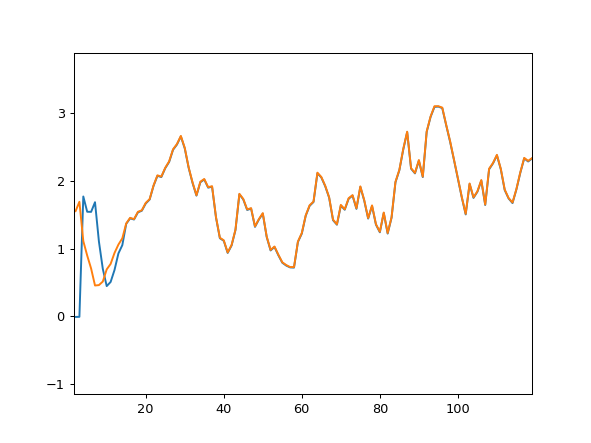

In [207]:
plt.figure()
plt.plot(np.array(ws['cursor'][1:]))
plt.plot(np.array(logger_aligned['decoder'][:,4]))

### offset the logger
typically, the logger is lagged by 1 frame because the way I start the BMI software is dumb and causes it to be lagged by 1 frame.

In [292]:
shift = 1
test = pd.DataFrame(
    indexing.shift_pad(
        array=ws,
        shift=shift,
        axis=0,
        pad_val=np.nan,
        in_place=False,
    ),
    columns=ws.columns
)

In [293]:
test

,licks,rewards,treadmill,cursor
0,NaN,NaN,NaN,NaN
1,0.0,0.0,1.252659,-0.008354
2,0.0,0.0,1.252659,-0.005395
3,0.0,0.0,1.252988,-0.006710
4,0.0,0.0,1.252659,-0.005395
...,...,...,...,...
107995,0.0,0.0,1.252330,2.860246
107996,0.0,0.0,1.251015,2.861561
107997,0.0,0.0,1.252659,2.861890
107998,0.0,0.0,1.253645,2.859259


<IPython.core.display.Javascript object>


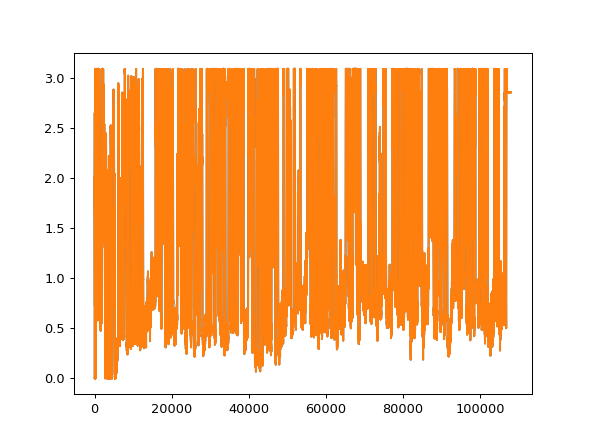

In [279]:
plt.figure()
plt.plot(ws['cursor'])
plt.plot(indexing.shift_pad(
    array=ws['cursor'],
    shift=1,
    axis=0,
    pad_val=np.nan,
    in_place=False,
))